In [1]:
import pandas as pd
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn import tree
import warnings
import tensorflow as tf
tf.__version__
warnings.filterwarnings('ignore')

In [2]:
loan_df=pd.read_csv('customer_loans.csv')
loan_df.head(5)

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,27,70000,MORTGAGE,11.0,PERSONAL,C,3000,NaN,0.04,Y,8,0
1,32,62000,RENT,5.0,MEDICAL,C,15000,12.99,0.24,Y,6,0
2,25,57000,RENT,3.0,MEDICAL,A,6850,NaN,0.12,N,4,0
3,33,34000,RENT,4.0,MEDICAL,D,10000,15.33,0.29,Y,8,1
4,35,62000,MORTGAGE,15.0,DEBTCONSOLIDATION,D,10000,15.33,0.16,N,10,1


## Data Preprocessing Steps

In [3]:
loan_df.shape

(10000, 12)

In [4]:
loan_df.columns

Index(['person_age', 'person_income', 'person_home_ownership',
       'person_emp_length', 'loan_intent', 'loan_grade', 'loan_amnt',
       'loan_int_rate', 'loan_percent_income', 'cb_person_default_on_file',
       'cb_person_cred_hist_length', 'loan_status'],
      dtype='object')

In [5]:
loan_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  10000 non-null  int64  
 1   person_income               10000 non-null  int64  
 2   person_home_ownership       10000 non-null  object 
 3   person_emp_length           9709 non-null   float64
 4   loan_intent                 10000 non-null  object 
 5   loan_grade                  10000 non-null  object 
 6   loan_amnt                   10000 non-null  int64  
 7   loan_int_rate               9015 non-null   float64
 8   loan_percent_income         10000 non-null  float64
 9   cb_person_default_on_file   10000 non-null  object 
 10  cb_person_cred_hist_length  10000 non-null  int64  
 11  loan_status                 10000 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 937.6+ KB


In [6]:
loan_df.describe()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,loan_status
count,10000.000000,1.000000e+04,9709.000000,10000.000000,9015.000000,10000.000000,10000.000000,10000.000000
mean,27.658300,6.656156e+04,4.794727,9637.337500,11.010956,0.169710,5.758800,0.222900
std,6.274032,5.570718e+04,4.216092,6425.962537,3.249357,0.106394,4.017043,0.416213
min,20.000000,6.000000e+03,0.000000,500.000000,5.420000,0.000000,2.000000,0.000000
25%,23.000000,3.879875e+04,2.000000,5000.000000,7.900000,0.090000,3.000000,0.000000
50%,26.000000,5.503900e+04,4.000000,8000.000000,10.990000,0.150000,4.000000,0.000000
75%,30.000000,8.000000e+04,7.000000,12275.000000,13.470000,0.230000,8.000000,0.000000
max,144.000000,2.039784e+06,123.000000,35000.000000,22.110000,0.770000,30.000000,1.000000


In [7]:
loan_df.isnull().sum()

person_age                      0
person_income                   0
person_home_ownership           0
person_emp_length             291
loan_intent                     0
loan_grade                      0
loan_amnt                       0
loan_int_rate                 985
loan_percent_income             0
cb_person_default_on_file       0
cb_person_cred_hist_length      0
loan_status                     0
dtype: int64

In [8]:
loan_df["person_emp_length"].fillna(loan_df["person_emp_length"].median(), inplace=True)

In [9]:
loan_df["loan_int_rate"].fillna(loan_df["loan_int_rate"].median(), inplace=True)

In [10]:
loan_df.isnull().sum()

person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
loan_status                   0
dtype: int64

In [11]:
loan_df.duplicated().sum()

19

In [12]:
loan_df.drop_duplicates(inplace=True)

In [13]:
def find_outliers(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    return df[(df[col] < Q1 - 1.5*IQR) | (df[col] > Q3 + 1.5*IQR)]

In [14]:
likely_outlier_cols = ["person_age","person_income","person_emp_length","cb_person_cred_hist_length"]
for col in likely_outlier_cols:
    print(find_outliers(loan_df, col).shape)

(459, 12)
(487, 12)
(257, 12)
(329, 12)


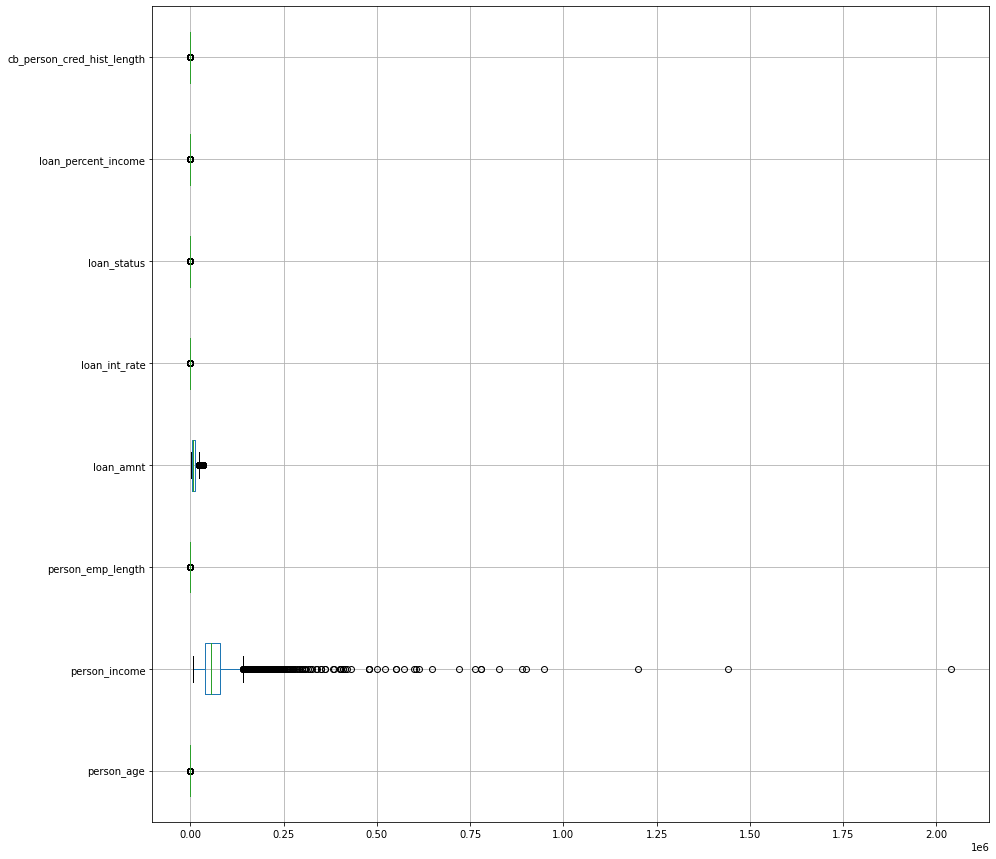

In [15]:
# box plot for continuous variables
plt.figure(figsize=(15,15))
loan_df[['person_age','person_income','person_emp_length','loan_amnt','loan_int_rate','loan_status','loan_percent_income','cb_person_cred_hist_length']].boxplot(vert=0)

In [16]:
def remove_outliers(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_range = Q1 - 1.5*IQR
    upper_range = Q3 + 1.5*IQR
    df[col] = np.where(df[col]>upper_range, upper_range, df[col])
    df[col] = np.where(df[col]<lower_range, lower_range, df[col])
    return df
for col in likely_outlier_cols:
    remove_outliers(loan_df, col)

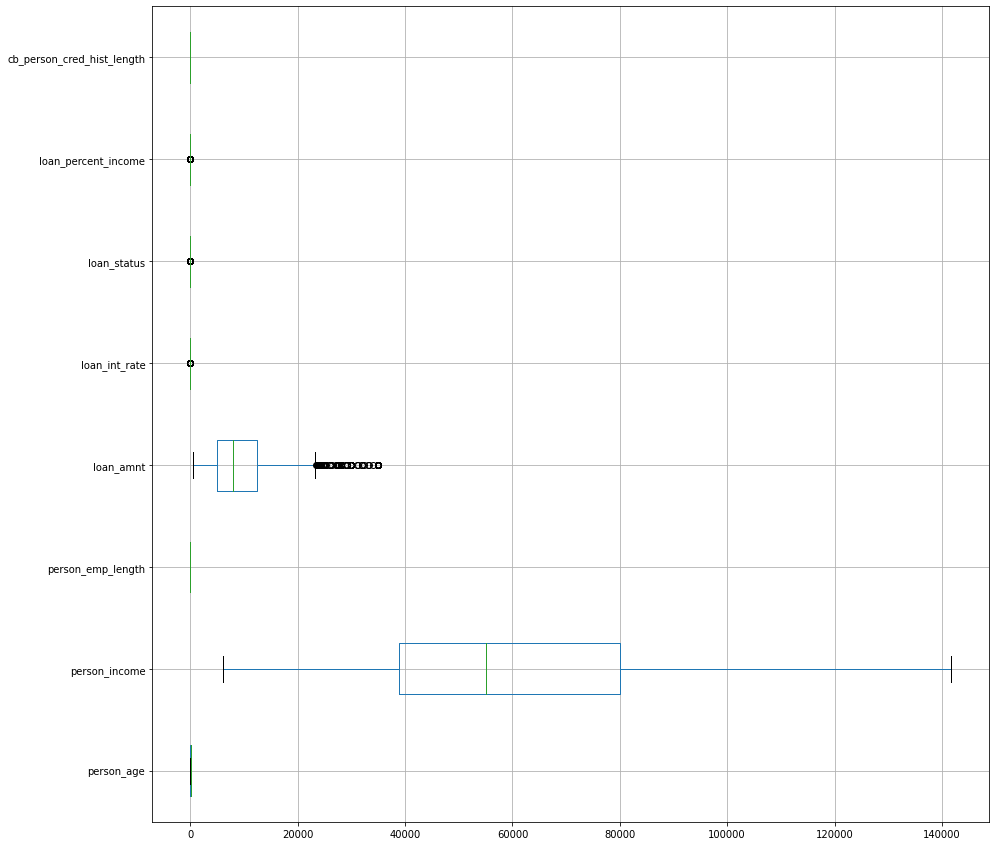

In [17]:
# construct box plot for continuous variables
plt.figure(figsize=(15,15))
loan_df[['person_age','person_income','person_emp_length','loan_amnt','loan_int_rate','loan_status','loan_percent_income','cb_person_cred_hist_length']].boxplot(vert=0)

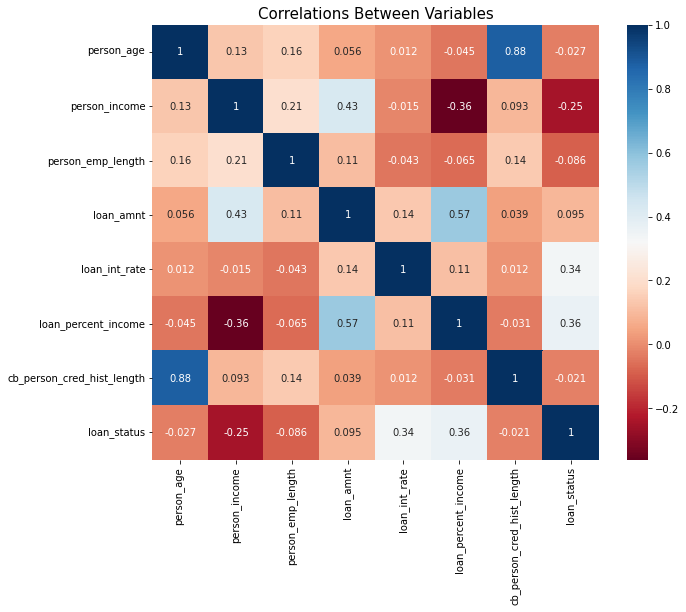

In [18]:
plt.figure(figsize=(10,8))
sns.heatmap(loan_df.corr(), annot=True, cmap="RdBu")
plt.title("Correlations Between Variables", size=15)
plt.show()

In [19]:
loan_df.person_home_ownership = loan_df.person_home_ownership.str.replace('RENT', '0')
loan_df.person_home_ownership = loan_df.person_home_ownership.str.replace('MORTGAGE', '1')
loan_df.person_home_ownership = loan_df.person_home_ownership.str.replace('OWN', '2')
loan_df.person_home_ownership = loan_df.person_home_ownership.str.replace('OTHER', '3')

loan_df.loan_intent = loan_df.loan_intent.str.replace('EDUCATION', '0')
loan_df.loan_intent = loan_df.loan_intent.str.replace('MEDICAL', '1')
loan_df.loan_intent = loan_df.loan_intent.str.replace('VENTURE', '2')
loan_df.loan_intent = loan_df.loan_intent.str.replace('PERSONAL', '3')
loan_df.loan_intent = loan_df.loan_intent.str.replace('DEBTCONSOLIDATION', '4')
loan_df.loan_intent = loan_df.loan_intent.str.replace('HOMEIMPROVEMENT', '5')

loan_df.loan_grade = loan_df.loan_grade.str.replace('A', '0')
loan_df.loan_grade = loan_df.loan_grade.str.replace('B', '1')
loan_df.loan_grade = loan_df.loan_grade.str.replace('C', '2')
loan_df.loan_grade = loan_df.loan_grade.str.replace('D', '3')
loan_df.loan_grade = loan_df.loan_grade.str.replace('E', '4')
loan_df.loan_grade = loan_df.loan_grade.str.replace('F', '5')
loan_df.loan_grade = loan_df.loan_grade.str.replace('G', '6')

loan_df.cb_person_default_on_file = loan_df.cb_person_default_on_file.str.replace('N', '0')
loan_df.cb_person_default_on_file = loan_df.cb_person_default_on_file.str.replace('Y', '1')

In [20]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
loan_dfx = loan_df.iloc[:,:-1].values
loan_dfy = loan_df.iloc[:,-1].values
loan_dfx[:, 2] = le.fit_transform(loan_dfx[:, 2])
loan_dfx[:, 4] = le.fit_transform(loan_dfx[:, 4])
loan_dfx[:, 5] = le.fit_transform(loan_dfx[:, 5])
loan_dfx[:, 9] = le.fit_transform(loan_dfx[:, 9])

In [21]:
loan_dfx

array([[27.0, 70000.0, 1, ..., 0.04, 1, 8.0],
       [32.0, 62000.0, 0, ..., 0.24, 1, 6.0],
       [25.0, 57000.0, 0, ..., 0.12, 0, 4.0],
       ...,
       [24.0, 60000.0, 1, ..., 0.04, 0, 4.0],
       [27.0, 120000.0, 1, ..., 0.12, 0, 7.0],
       [26.0, 51996.0, 1, ..., 0.35, 0, 3.0]], dtype=object)

In [22]:
loan_dfx[0]

array([27.0, 70000.0, 1, 11.0, 3, 2, 3000, 10.99, 0.04, 1, 8.0],
      dtype=object)

In [23]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, Ytrain, Ytest = train_test_split(loan_dfx,loan_dfy,test_size = 0.2,random_state =2)

In [24]:
Xtrain

array([[23.0, 45996.0, 2, ..., 0.22, 0, 3.0],
       [30.0, 58000.0, 1, ..., 0.09, 0, 9.0],
       [28.0, 50000.0, 0, ..., 0.08, 0, 10.0],
       ...,
       [24.0, 26400.0, 0, ..., 0.19, 0, 4.0],
       [27.0, 127000.0, 1, ..., 0.17, 0, 5.0],
       [25.0, 35000.0, 0, ..., 0.03, 0, 3.0]], dtype=object)

In [25]:
# Initialzing empty lists to append all model's name and corresponding name
acc = []
model = []

In [26]:
from sklearn.tree import DecisionTreeClassifier

DecisionTree = DecisionTreeClassifier(criterion="entropy",random_state=2,max_depth=5)

DecisionTree.fit(Xtrain,Ytrain)

predicted_values = DecisionTree.predict(Xtest)
x = metrics.accuracy_score(Ytest, predicted_values)
acc.append(x)
model.append('Decision Tree')
print("DecisionTrees's Accuracy is: ", x*100)

print(classification_report(Ytest,predicted_values))

DecisionTrees's Accuracy is:  91.13670505758637
              precision    recall  f1-score   support

           0       0.91      0.99      0.95      1557
           1       0.93      0.65      0.76       440

    accuracy                           0.91      1997
   macro avg       0.92      0.82      0.85      1997
weighted avg       0.91      0.91      0.91      1997



In [27]:
from sklearn.model_selection import cross_val_score
score = cross_val_score(DecisionTree, loan_dfx, loan_dfy,cv=5)
score

array([0.89884827, 0.92034068, 0.91082164, 0.91232465, 0.90881764])

In [28]:
# Gausian Naive Bayes
from sklearn.naive_bayes import GaussianNB

NaiveBayes = GaussianNB()

NaiveBayes.fit(Xtrain,Ytrain)

predicted_values = NaiveBayes.predict(Xtest)
x = metrics.accuracy_score(Ytest, predicted_values)
acc.append(x)
model.append('Naive Bayes')
print("Naive Bayes's Accuracy is: ", x)

print(classification_report(Ytest,predicted_values))

Naive Bayes's Accuracy is:  0.8367551326990486
              precision    recall  f1-score   support

           0       0.85      0.95      0.90      1557
           1       0.72      0.43      0.54       440

    accuracy                           0.84      1997
   macro avg       0.79      0.69      0.72      1997
weighted avg       0.82      0.84      0.82      1997



In [29]:
# SVM
from sklearn.svm import SVC
# data normalization with sklearn
from sklearn.preprocessing import MinMaxScaler
# fit scaler on training data
norm = MinMaxScaler().fit(Xtrain)
X_train_norm = norm.transform(Xtrain)
# transform testing dataabs
X_test_norm = norm.transform(Xtest)
SVM = SVC(kernel='poly', degree=3, C=1)
SVM.fit(X_train_norm,Ytrain)
predicted_values = SVM.predict(X_test_norm)
x = metrics.accuracy_score(Ytest, predicted_values)
acc.append(x)
model.append('SVM')
print("SVM's Accuracy is: ", x)

print(classification_report(Ytest,predicted_values))

SVM's Accuracy is:  0.8743114672008012
              precision    recall  f1-score   support

           0       0.87      0.98      0.92      1557
           1       0.88      0.50      0.64       440

    accuracy                           0.87      1997
   macro avg       0.88      0.74      0.78      1997
weighted avg       0.87      0.87      0.86      1997



In [30]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression

LogReg = LogisticRegression(random_state=2)

LogReg.fit(Xtrain,Ytrain)

predicted_values = LogReg.predict(Xtest)

x = metrics.accuracy_score(Ytest, predicted_values)
acc.append(x)
model.append('Logistic Regression')
print("Logistic Regression's Accuracy is: ", x)

print(classification_report(Ytest,predicted_values))

Logistic Regression's Accuracy is:  0.800200300450676
              precision    recall  f1-score   support

           0       0.81      0.98      0.88      1557
           1       0.69      0.17      0.27       440

    accuracy                           0.80      1997
   macro avg       0.75      0.57      0.58      1997
weighted avg       0.78      0.80      0.75      1997



In [31]:
# RF
from sklearn.ensemble import RandomForestClassifier

RF = RandomForestClassifier(n_estimators=20, random_state=0)
RF.fit(Xtrain,Ytrain)

predicted_values = RF.predict(Xtest)

x = metrics.accuracy_score(Ytest, predicted_values)
acc.append(x)
model.append('RF')
print("RF's Accuracy is: ", x)

print(classification_report(Ytest,predicted_values))

RF's Accuracy is:  0.9183775663495243
              precision    recall  f1-score   support

           0       0.92      0.98      0.95      1557
           1       0.92      0.69      0.79       440

    accuracy                           0.92      1997
   macro avg       0.92      0.84      0.87      1997
weighted avg       0.92      0.92      0.91      1997



In [32]:
import xgboost as xgb
XB = xgb.XGBClassifier()
XB.fit(Xtrain,Ytrain)

predicted_values = XB.predict(Xtest)

x = metrics.accuracy_score(Ytest, predicted_values)
acc.append(x)
model.append('XGBoost')
print("XGBoost's Accuracy is: ", x)

XGBoost's Accuracy is:  0.9233850776164246


# Aritificial Neural Networks

In [33]:
# feature scaling is a must for deep learning...we must just scale every column..even if they have 1/0/short range values
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
Xtrain = sc.fit_transform(Xtrain)
Xtest = sc.transform(Xtest)# dont fit here....it must be fitted to train range
# cuz later u have to transform input and for that gotta us ethis same sc

In [34]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import BatchNormalization

# initializing ann
ANN = Sequential()

# adding the first input layer and the first hidden layer
ANN.add(Dense(11, kernel_initializer = 'normal', activation = 'relu'))

# adding batch normalization and dropout layer
ANN.add(Dropout(rate = 0.1))
ANN.add(BatchNormalization())

# adding the third hidden layer
ANN.add(Dense(8, kernel_initializer = 'normal', activation = 'relu'))

# adding batch normalization and dropout layer
ANN.add(Dropout(rate = 0.1))
ANN.add(BatchNormalization())

# adding the output layer
ANN.add(Dense(1, kernel_initializer = 'normal', activation = 'sigmoid'))

# compiling the model
ANN.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

# fitting the model to the training set 

model_history = ANN.fit(Xtrain, Ytrain, validation_split = 0.20, validation_data = (Xtest, Ytest), epochs = 100)

Epoch 1/100
200/200 [==============================] - 2s 4ms/step - loss: 0.5645 - accuracy: 0.7642 - val_loss: 0.5358 - val_accuracy: 0.7846
Epoch 2/100
200/200 [==============================] - 1s 3ms/step - loss: 0.4139 - accuracy: 0.8448 - val_loss: 0.4156 - val_accuracy: 0.8197
Epoch 3/100
200/200 [==============================] - 1s 3ms/step - loss: 0.3634 - accuracy: 0.8547 - val_loss: 0.3391 - val_accuracy: 0.8691
Epoch 4/100
200/200 [==============================] - 1s 3ms/step - loss: 0.3537 - accuracy: 0.8574 - val_loss: 0.3226 - val_accuracy: 0.8779
Epoch 5/100
200/200 [==============================] - 1s 3ms/step - loss: 0.3426 - accuracy: 0.8591 - val_loss: 0.3129 - val_accuracy: 0.8760
Epoch 6/100
200/200 [==============================] - 1s 3ms/step - loss: 0.3394 - accuracy: 0.8630 - val_loss: 0.3190 - val_accuracy: 0.8741
Epoch 7/100
200/200 [==============================] - 1s 3ms/step - loss: 0.3366 - accuracy: 0.8608 - val_loss: 0.3089 - val_accuracy: 0.8791

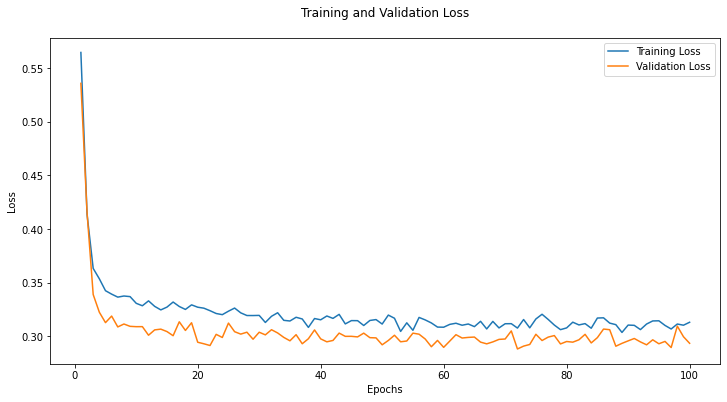

In [35]:
plt.figure(figsize = (12, 6))

train_loss = model_history.history['loss']
val_loss = model_history.history['val_loss'] 
epoch = range(1, 101)
sns.lineplot(epoch, train_loss, label = 'Training Loss')
sns.lineplot(epoch, val_loss, label = 'Validation Loss')
plt.title('Training and Validation Loss\n')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

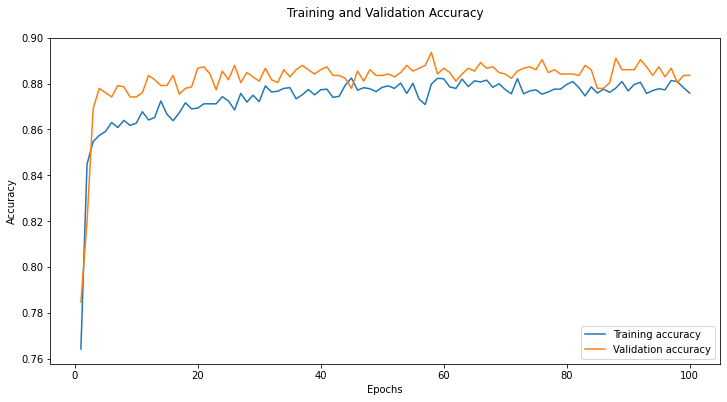

In [36]:
plt.figure(figsize = (12, 6))

train_loss = model_history.history['accuracy']
val_loss = model_history.history['val_accuracy'] 
epoch = range(1, 101)
sns.lineplot(epoch, train_loss, label = 'Training accuracy')
sns.lineplot(epoch, val_loss, label = 'Validation accuracy')
plt.title('Training and Validation Accuracy\n')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [37]:
y_pred = ANN.predict(Xtest) 
y_pred = (y_pred > 0.5)
print(np.concatenate((y_pred.reshape(len(y_pred),1), Ytest.reshape(len(Ytest),1)),1))

[[0 0]
 [0 0]
 [0 0]
 ...
 [0 0]
 [0 0]
 [0 0]]


In [38]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(Ytest, y_pred)
print(cm)
print(accuracy_score(Ytest, y_pred))

[[1534   23]
 [ 210  230]]
0.8833249874812218


In [39]:
acc.append(accuracy_score(Ytest, y_pred))
model.append('ANN')

# Accuracy Comparision

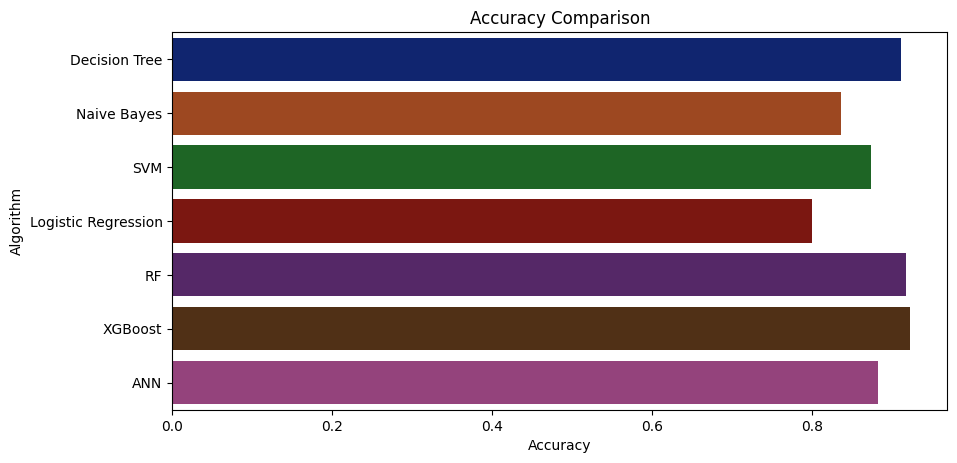

In [40]:
plt.figure(figsize=[10,5],dpi = 100)
plt.title('Accuracy Comparison')
plt.xlabel('Accuracy')
plt.ylabel('Algorithm')
sns.barplot(x = acc,y = model,palette='dark')

In [41]:
accuracy_models = dict(zip(model, acc))
for k, v in accuracy_models.items():
    print (k, '-->', v)

Decision Tree --> 0.9113670505758638
Naive Bayes --> 0.8367551326990486
SVM --> 0.8743114672008012
Logistic Regression --> 0.800200300450676
RF --> 0.9183775663495243
XGBoost --> 0.9233850776164246
ANN --> 0.8833249874812218


In [42]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [43]:
import shap

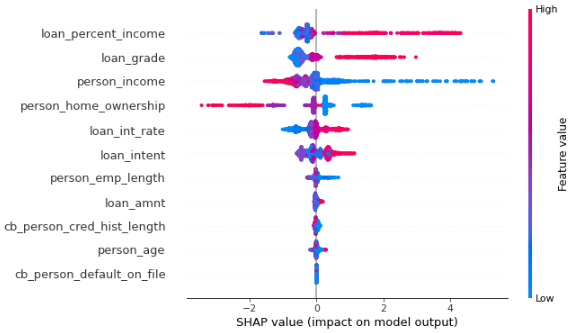

In [44]:
# Create object that can calculate shap values
explainer = shap.TreeExplainer(XB)

# calculate shap values. This is what we will plot.
# Calculate shap_values for all of val_X rather than a single row, to have more data for plot.
shap_values = explainer.shap_values(Xtest)

# Make plot. Index of [1] is explained in text below.
shap.summary_plot(shap_values, Xtest, feature_names = ['person_age', 'person_income', 'person_home_ownership', 'person_emp_length', 'loan_intent', 'loan_grade', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_default_on_file', 'cb_person_cred_hist_length'])